In [36]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from gm_function import *

In [37]:
#CHANGE VALUES HERE#
# H for Healthy and S for Stroke 
participant_id = 'S002'
participant_group = 'S'
# For stroke, dominant hand = non affected hand 
dominant_hand = 'Right'

In [ ]:
# For debugging 
if participant_group == 'H':
    print(f"Participant Dominant Hand (Healthy Group): {dominant_hand}")
else: # Stroke group
    print(f"Non-affected Hand (Stroke Group): {dominant_hand}")

In [38]:
#PATH 
initial_path = '../CreateStudy'
# Join the initial_path and participant_id
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\S002


In [39]:
# Get the data from csv files 
ndh_data, chest_data, dh_data, GT_mask_ndh, GT_mask_dh = get_data(participant_path, dominant_hand)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_ndh)*2, len(ndh_data))

61706 61706


In [40]:
# Useful variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [41]:
# Get AC values 
AC_ndh_filename = 'count_brond_ndh.csv'
AC_dh_filename = 'count_brond_dh.csv'
AC_ndh_path = os.path.join(participant_path, AC_ndh_filename)
AC_dh_path = os.path.join(participant_path, AC_dh_filename)
AC_ndh, AC_dh = read_csv_to_numpy(AC_ndh_path, AC_dh_path)

In [42]:
# MASK with WBM replaced by NF #

In [43]:
# Create masks with WBM converted into NF movement

GT_mask_ndh_1Hz = downsample_mask_interpolation(GT_mask_ndh, FPS_mask, frequency_AC)
GT_mask_dh_1Hz = downsample_mask_interpolation(GT_mask_dh, FPS_mask, frequency_AC)
GT_mask_ndh_2Hz = downsample_mask_interpolation(GT_mask_ndh, FPS_mask, frequency_GM)
GT_mask_dh_2Hz = downsample_mask_interpolation(GT_mask_dh, FPS_mask, frequency_GM)

# Replace WBM mask by NF masks @ 25Hz 
GT_mask_ndh_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh).ravel()
GT_mask_dh_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh).ravel()

# Replace WBM mask by NF masks @ 2Hz 
GT_mask_ndh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_2Hz)
GT_mask_dh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_2Hz)

# Replace WBM mask by NF masks @ 1Hz 
GT_mask_ndh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_1Hz)
GT_mask_dh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_1Hz)

# Trim dataset to ensure same size 
GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh = remove_extra_elements(GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh)
GT_mask_dh_1Hz_wbm_into_nf, AC_dh = remove_extra_elements(GT_mask_dh_1Hz_wbm_into_nf, AC_dh)

# Upsample the masks 
GT_mask_50Hz_ndh = resample_mask(GT_mask_ndh_wbm_into_nf, 25.0, 50.0)
GT_mask_50Hz_dh = resample_mask(GT_mask_dh_wbm_into_nf, 25.0, 50.0)

In [44]:
## GM Algorithm ##

In [45]:
# Get Euler angles 

# Left wrist
roll_mad_ndh, pitch_mad_ndh, yaw_mad_ndh = compute_euler_angles(acc_ndh, gyro_ndh, sampling_freq)
# Right wrist 
roll_mad_dh, pitch_mad_dh, yaw_mad_dh = compute_euler_angles(acc_dh, gyro_dh, sampling_freq)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [46]:
# Ensure the datasets have the same sizes 
# For ndh
pitch_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(pitch_mad_ndh, GT_mask_50Hz_ndh)
yaw_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(yaw_mad_ndh, GT_mask_50Hz_ndh)
# For dh
pitch_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(pitch_mad_dh, GT_mask_50Hz_dh)
yaw_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(yaw_mad_dh, GT_mask_50Hz_dh)

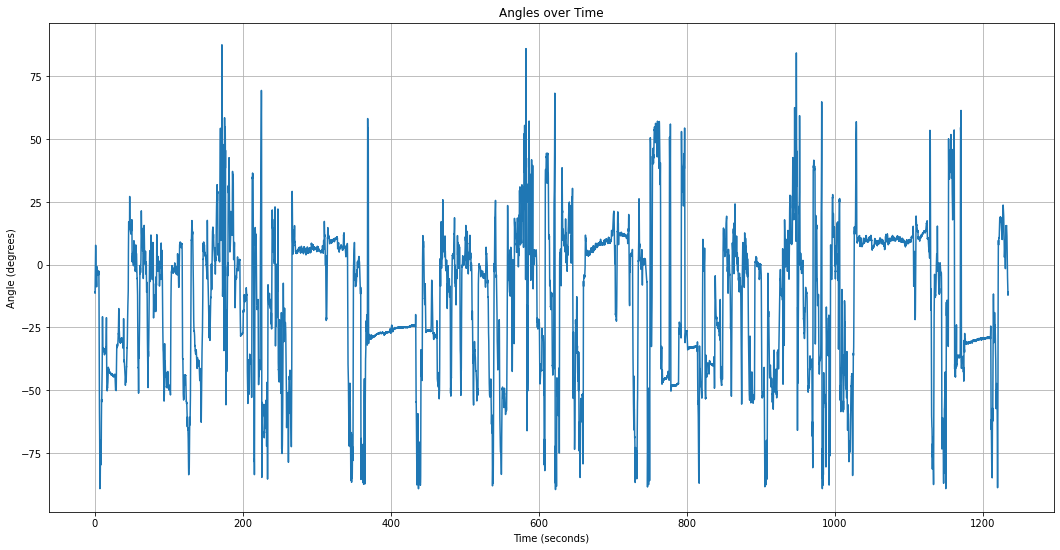

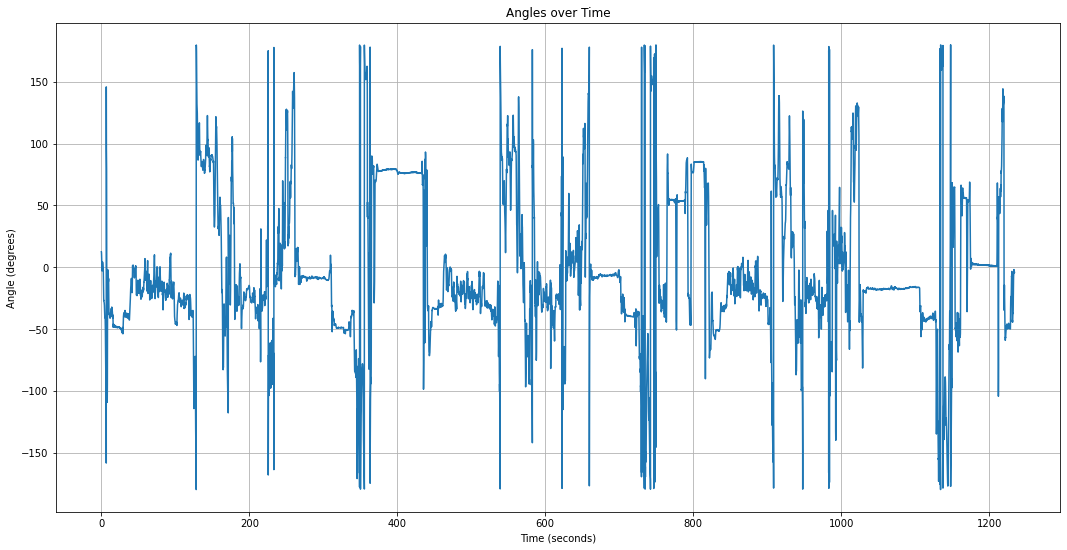

In [47]:
plot_angles_over_time(pitch_mad_ndh)
plot_angles_over_time(yaw_mad_ndh)

In [48]:
# Save the datasets as CSV files 
save_gm_arrays_as_csv(pitch_mad_ndh, yaw_mad_ndh, pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_ndh, GT_mask_50Hz_dh, participant_path)

CSV file saved successfully.
CSV saved at: ../CreateStudy\S002\gm_datasets.csv


In [49]:
# Computation of an optimal FS for the GM algorithm # 

In [50]:
# Optimal Left wrist 
eval_metrics_fs_opt_ndh, optimal_fs_ndh = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                                               k=5, random_state=42, optimal=True)

# Conventional Left wrist 
eval_metrics_fs_conv_ndh, _ = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                                    k=5, random_state=42, optimal=False)

In [51]:
# Optimal Right wrist 
eval_metrics_fs_opt_dh, optimal_fs_dh = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                                               k=5, random_state=42, optimal=True)

# Conventional Right wrist 
eval_metrics_fs_conv_dh, _ = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                                    k=5, random_state=42, optimal=False)

In [52]:
# Optimal Bilateral 
eval_metrics_fs_opt_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=True)

# Conventional Bilateral 
eval_metrics_fs_conv_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=False)

In [53]:
print(optimal_fs_ndh, optimal_fs_dh)

55.0 51.0


In [54]:
eval_metrics_fs_conv_bil

{'Sensitivity': 57.42958515844666,
 'Specificity': 73.73612346688253,
 'Accuracy': 63.935091277890464,
 'PPV': 76.73625530172488,
 'NPV': 53.46194615032764}

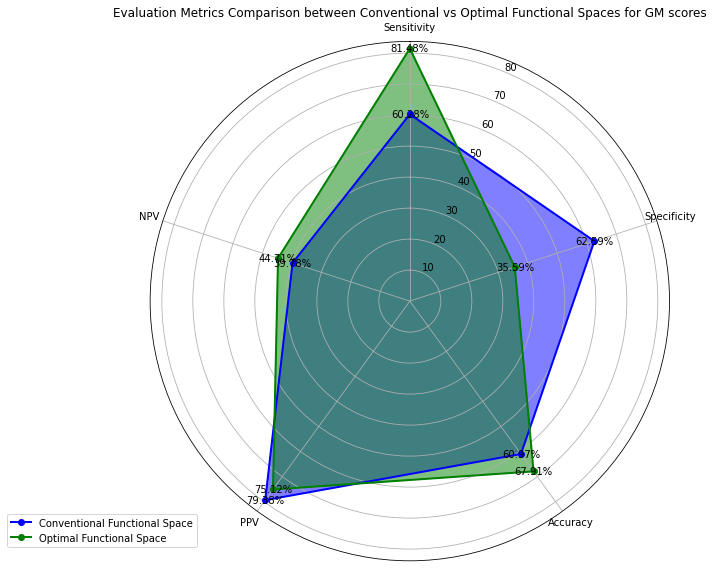

In [55]:
plot_radar_chart(eval_metrics_fs_conv_ndh, eval_metrics_fs_opt_ndh, metric = 'GM')

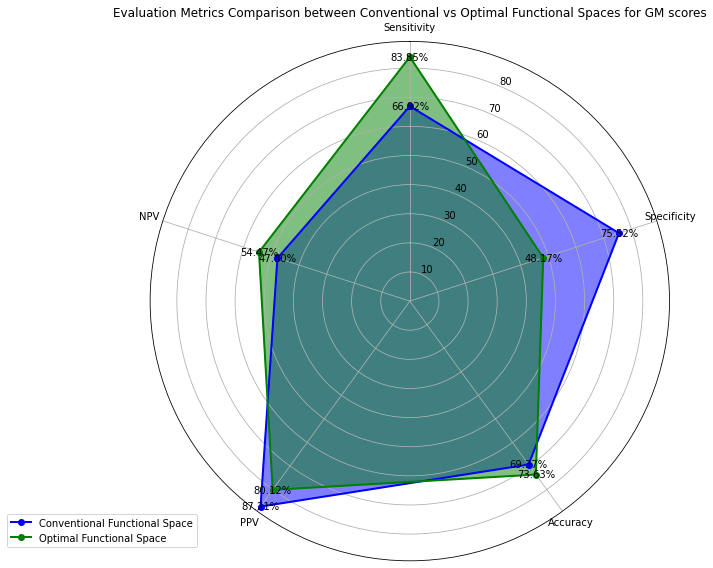

In [56]:
plot_radar_chart(eval_metrics_fs_conv_dh, eval_metrics_fs_opt_dh, metric = 'GM')

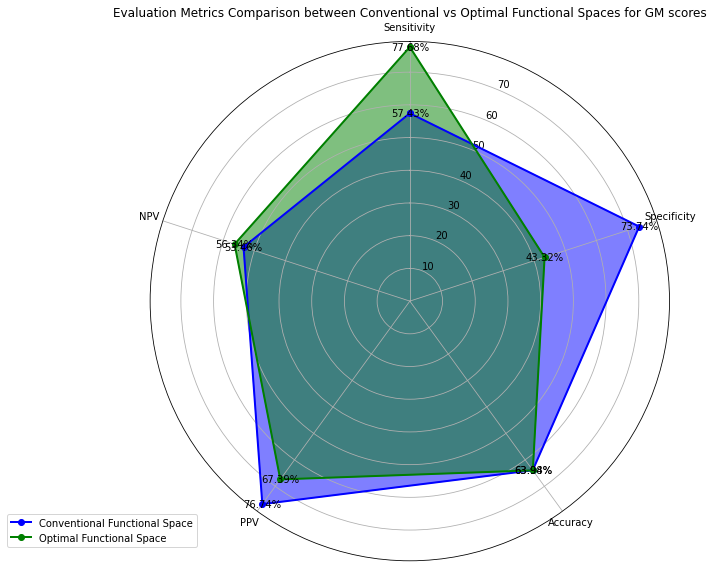

In [57]:
plot_radar_chart(eval_metrics_fs_conv_bil, eval_metrics_fs_opt_bil, metric = 'GM')

In [58]:
# Saving data for this participant 

In [59]:
# Create a structure to save all the metrics 
metrics_dictionary_GM = create_metrics_dictionary(eval_metrics_fs_conv_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_conv_bil, eval_metrics_fs_opt_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_opt_bil)

In [60]:
# Save metrics as csv file: evaluation metrics on unseen data 
save_metrics_dictionary_as_csv(metrics_dictionary_GM, participant_path, metric = 'GM')
# Save optimal AC threhshold for this participant 
save_optimal_threshold(participant_path, optimal_fs_ndh, optimal_fs_dh, AC=False, group='S')

The metrics dictionary has been saved as ../CreateStudy\S002\evaluation_metrics_GM.csv.
Thresholds saved successfully at: ../CreateStudy\S002\S_optimal_threshold_GM.csv


In [74]:
# GMAC # 

In [75]:
opt_ac_threshold_ndh, opt_ac_threshold_dh = load_optimal_threshold(participant_path, participant_group='S', AC=True)

Thresholds loaded successfully from: ../CreateStudy\S002\S_optimal_threshold_AC.csv


In [76]:
# For the NDH 
gmac_ndh_conv = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_ndh = get_evaluation_metrics(GT_mask_ndh_1Hz_wbm_into_nf, gmac_ndh_conv)

gmac_ndh_opt = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = opt_ac_threshold_ndh, functional_space = optimal_fs_ndh)
eval_metrics_gmac_opt_ndh = get_evaluation_metrics(GT_mask_ndh_1Hz_wbm_into_nf, gmac_ndh_opt)

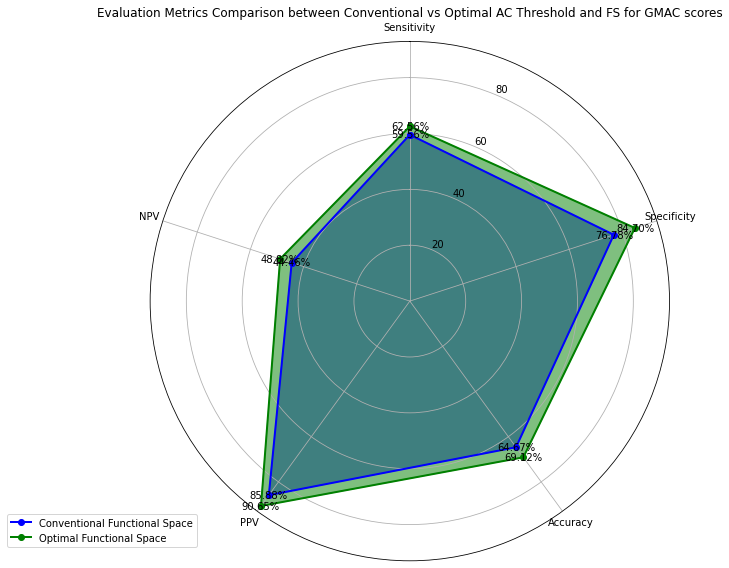

In [77]:
plot_radar_chart(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_opt_ndh, metric = 'GMAC')

In [65]:
# For the DH 
gmac_dh_conv = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_dh = get_evaluation_metrics(GT_mask_dh_1Hz_wbm_into_nf, gmac_dh_conv)

gmac_dh_opt = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = opt_ac_threshold_dh, functional_space = optimal_fs_dh)
eval_metrics_gmac_opt_dh = get_evaluation_metrics(GT_mask_dh_1Hz_wbm_into_nf, gmac_dh_opt)

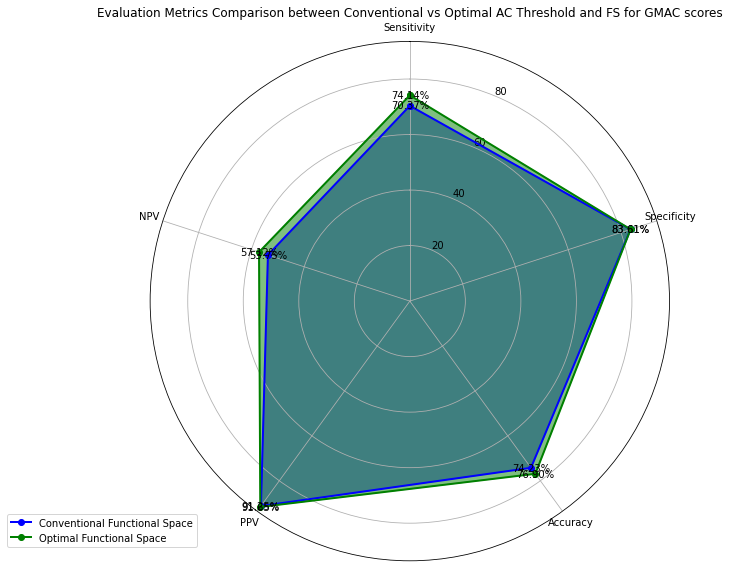

In [66]:
plot_radar_chart(eval_metrics_gmac_conv_dh, eval_metrics_gmac_opt_dh, metric = 'GMAC')

In [67]:
# For the bilateral usage 
# Use a simple logical AND 
# Mask 
GT_mask_bil_1Hz = get_mask_bilateral(GT_mask_ndh_1Hz_wbm_into_nf, GT_mask_dh_1Hz_wbm_into_nf)

# Conv
gmac_bil_conv = get_mask_bilateral(gmac_ndh_conv, gmac_dh_conv)
eval_metrics_gmac_conv_bil = get_evaluation_metrics(GT_mask_bil_1Hz, gmac_bil_conv)

# Opti
gmac_bil_opt = get_mask_bilateral(gmac_ndh_opt, gmac_dh_opt)
eval_metrics_gmac_opt_bil = get_evaluation_metrics(GT_mask_bil_1Hz, gmac_bil_opt)

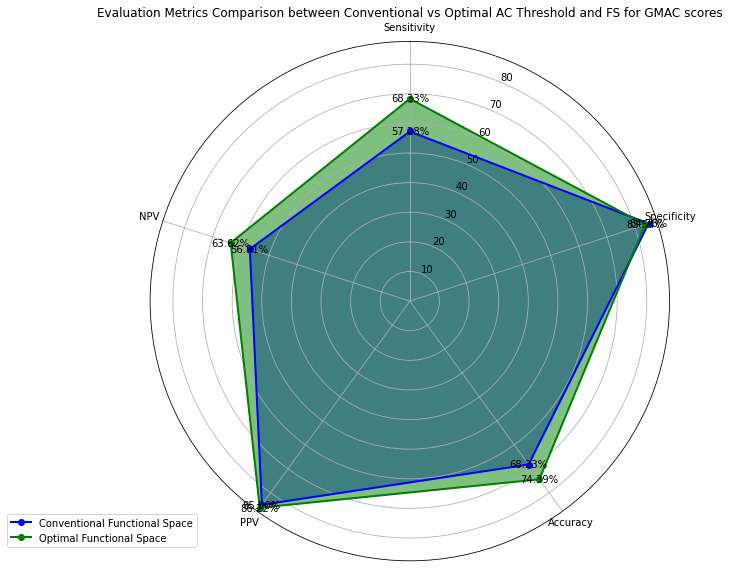

In [68]:
plot_radar_chart(eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_bil, metric = 'GMAC')

In [69]:
# Create a structure to save all the metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_conv_dh, eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_ndh, eval_metrics_gmac_opt_dh, eval_metrics_gmac_opt_bil)

In [70]:
# Save individual eval metrics for GMAC scores 
save_metrics_dictionary_as_csv(metrics_dictionary_GMAC, participant_path, metric='GMAC')

The metrics dictionary has been saved as ../CreateStudy\S002\evaluation_metrics_GMAC.csv.
